This notebook demonstrates how to use ImageAnalyzer class to calculate statistics of post stamps.

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from lsst import geom
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [162]:
# Read data
diaSrc_repo = '/global/u1/s/shl159/GitHub/al_181868_58'
diaSrc_butler = Butler(diaSrc_repo)
visit, detector, filt = 181868, 57, 'r'
dataset_type = 'deepDiff_differenceExp'
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
exposure = diaSrc_butler.get(dataset_type, dataId=calexp_id)

In [163]:
from astropy.table import Table
t = Table.read('/global/u1/s/shl159/GitHub/al_181868_58/deepDiff/v00181868-fr/R13/diaSrc_00181868-r-R13-S10-det057.fits')

# 1. Image Analyzer Class

In [164]:
class ImageAnalyzer(object):
    def __init__(self, exposure, xpos=None, ypos=None):
        # Initialize the analyzer with an exposure.
        # xpos and ypos are coordinates where we want to create post stamps.
        # If xpos and ypos are not give, the analyzer will pick each 60*60 successive region
        # as post stamps.
        self.exposure = exposure
        self.xpos = xpos
        self.ypos = ypos
        
        if xpos is None or ypos is None:
            height, width = exposure.getImage().array.shape
            self.xpos = np.arange(130, width-30, 60)
            self.ypos = np.arange(130, height-30, 60)    
        else:
            self.xpos = xpos
            self.ypos = ypos
        
        # Calculate mean of image, variance of image, mean of vari
        image, vari, mask = ImageAnalyzer.unpack_exposure(self.exposure)
        self.clip_image, _, _ = stats.sigmaclip(
            ImageAnalyzer.mask_data(image, mask, fill=False)
        )
        self.clip_variance, _, _ = stats.sigmaclip(
            ImageAnalyzer.mask_data(vari, mask, fill=False)
        )
        self.mean, self.vari_image, self.mean_of_vari = ImageAnalyzer._cal_mean_vari(self.clip_image, self.clip_variance)
        
        # Calculate covariance
        norm  = ImageAnalyzer.mask_data(image/np.sqrt(vari), mask,
                                                  fill=True, fill_value = 0)
        self.cov_matrix, self.cov = ImageAnalyzer.cal_covariance(norm)
        
    @staticmethod
    def unpack_exposure(exposure):
        # Unpack an exposure to image, variance, and mask.
        image = exposure.getImage().array
        vari = exposure.getVariance().array
        mask = exposure.getMask().array == 0
        return image, vari, mask
    
    @staticmethod
    def translateMask(self, mask):
        pass
    
    @staticmethod
    def mask_data(data, mask, fill=False, fill_value=0):
        # If fill is True, the data at mask=True would be return. It is a flattened array.
        # If fill is False, the data at mask=True would be replaced by fill_value, a 2d
        # array will be return.
        data2 = data.copy()
        if not np.any(mask):
            return None
        elif fill is True:
            data2[mask] = fill_value
            return data2
        else:
            return data2[mask].flatten()
    
    @staticmethod
    def _cal_mean_vari(image, vari):
        # Calculate the mean of the image array, the variance of the image, and the 
        # mean of the vari array.
        mean = np.mean(image)
        vari_image = np.var(image, ddof=1)
        mean_of_vari = np.mean(vari)
        return mean, vari_image, mean_of_vari
    
    @staticmethod
    def cal_covariance(norm_data):
        # Calculate the covariance of a normalized data (image / sqrt(variance))

        shifted_imgs = [
            norm_data,
            np.roll(norm_data, 1, 0), np.roll(norm_data, -1, 0),
            np.roll(norm_data, 1, 1), np.roll(norm_data, -1, 1),
            np.roll(np.roll(norm_data, 1, 0), 1, 1), np.roll(np.roll(norm_data, 1, 0), -1, 1),
            np.roll(np.roll(norm_data, -1, 0), 1, 1), np.roll(np.roll(norm_data, -1, 0), -1, 1),
            np.roll(norm_data, 2, 0), np.roll(norm_data, -2, 0),
            np.roll(norm_data, 2, 1), np.roll(norm_data, -2, 1),
            np.roll(norm_data, 3, 0), np.roll(norm_data, -3, 0),
            np.roll(norm_data, 3, 1), np.roll(norm_data, -3, 1),
            np.roll(norm_data, 4, 0), np.roll(norm_data, -4, 0),
            np.roll(norm_data, 4, 1), np.roll(norm_data, -4, 1),
            np.roll(norm_data, 5, 0), np.roll(norm_data, -5, 0),
            np.roll(norm_data, 5, 1), np.roll(norm_data, -5, 1),
            np.roll(np.roll(norm_data, 2, 0), 1, 1), np.roll(np.roll(norm_data, 2, 0), -1, 1),
            np.roll(np.roll(norm_data, -2, 0), 1, 1), np.roll(np.roll(norm_data, -2, 0), -1, 1),
            np.roll(np.roll(norm_data, 1, 0), 2, 1), np.roll(np.roll(norm_data, 1, 0), -2, 1),
            np.roll(np.roll(norm_data, -1, 0), 2, 1), np.roll(np.roll(norm_data, -1, 0), -2, 1),
            np.roll(np.roll(norm_data, 2, 0), 2, 1), np.roll(np.roll(norm_data, 2, 0), -2, 1),
            np.roll(np.roll(norm_data, -2, 0), 2, 1), np.roll(np.roll(norm_data, -2, 0), -2, 1),
        ]
        shifted_imgs = np.vstack([i.flatten() for i in shifted_imgs])
        covariance_matrix = np.cov(shifted_imgs, bias=1)
        trace = np.trace(covariance_matrix)
        covariance = (np.sum(covariance_matrix) - trace) / trace
        return covariance_matrix, covariance
    
    def make_cutout(self, xpos, ypos, cutout_size=60):
        # Make a cutout exposure at (xpos, ypos).
        cutout_extent = geom.ExtentI(cutout_size, cutout_size)
        radec = geom.SpherePoint(self.exposure.getWcs().pixelToSky(xpos, ypos))
        cutout_image = self.exposure.getCutout(radec, cutout_extent)
        return cutout_image
    
    
    @staticmethod
    def display_cutout(cutout_image, xpos, ypos, title='cutout image'):
        # Display the cutout image.
        plt.figure()
        xy = geom.Point2I(xpos, ypos)
        display = afwDisplay.Display(frame=None, backend='matplotlib')
        display.mtv(cutout_image)
        display.scale("linear", "zscale")
        display.dot('o', xy.getX(), xy.getY(), ctype='red')
        display.show_colorbar()
        plt.title(title)
    
    @staticmethod
    def plot_hist(data, title='histogram'):
        # Plot the histogram of data.
        rv10 = stats.norm(loc=0., scale=1.0)
        rv12 = stats.norm(loc=0., scale=1.2)
        rv14 = stats.norm(loc=0., scale=1.4)
        x = np.arange(-5,5.1,0.1)

        plt.figure()
        plt.hist(data.ravel(), bins='auto', density=True, label='pixel distribution')
        plt.xlim(-10, 10)
        plt.plot(x, rv10.pdf(x), label='sigma=1.0')
        plt.plot(x, rv12.pdf(x), label='sigma=1.2')
        plt.plot(x, rv14.pdf(x), label='sigma=1.4')
        plt.title(title)
        plt.legend()
        
    @staticmethod
    # Plot the covariance matrix.
    def plot_cov(cov_matrix, title='covariance matrix'):
        plt.figure()
        plt.imshow(cov_matrix)
        plt.title(title)
        plt.colorbar()


    def cutout_analysis(self, xpos, ypos, cutout_size=60,
                        fill=False, fill_value=0, clip_image=True,
                        alpha=0.05,
                        image_show=False, hist_show=False, cov_show=False):
        """Calculate statistics of a cutout exposure.
        Parameters:
        fill: Fill the mask=True pixels with fill_value
        clip_image: Do sigmaclip to image and variance
        alpha: The significance value of the hypothesis test
        Returns:
        Mean: Mean of the image
        vari_image: variance of the image
        mean_of_vari: Mean of the variance plane
        standard_norm_p: P value for testing whehter the normlized post stamp is consisntent with
                         the standard normal distribution
        standard_norm_test: Whether the normlized post stamp is consisntent with the standard
                            normal distribution
        skybk_p: P value for testing whether the post stamp and the sky background are from the same 
                 distribution
        skybk_test: Whether the post stamp and the sky background are from the same distribution
        covariance: Covariance of the post stamp
        """
        
        
        analysis_list = ['mean', 'vari_image', 'mean_of_vari', 'standard_norm_p',
                         'standard_norm_test', 'skybk_p', 'skybk_test', 'covariance']
        
        cutout_image = self.make_cutout(xpos, ypos, cutout_size=cutout_size)
        image, vari, mask = ImageAnalyzer.unpack_exposure(cutout_image)
            
        mask_image = ImageAnalyzer.mask_data(image, mask, fill=fill, fill_value=fill_value)
        mask_vari = ImageAnalyzer.mask_data(vari, mask, fill=fill, fill_value=fill_value)

        if mask_image is None or mask_vari is None:
            print('All pixels of this post-stamp are masked.')
            return dict(zip(analysis_list, [None]*len(analysis_list))) 
        
        # calculate mean and variance
        if clip_image is True:
            clip_image, _, _ = stats.sigmaclip(mask_image)
            clip_vari, _, _ = stats.sigmaclip(mask_vari)
            mean, vari_image, mean_of_vari = ImageAnalyzer._cal_mean_vari(clip_image, clip_vari) 
        else:
            mean, vari_image, mean_of_vari = ImageAnalyzer._cal_mean_vari(mask_image, mask_vari) 
        
        # normalize image
        if fill is True:
            mask_image2 = ImageAnalyzer.mask_data(image, mask, fill=False)
            mask_vari2 = ImageAnalyzer.mask_data(vari, mask, fill=False)
            norm_image = mask_image2 / np.sqrt(mask_vari2)
        else:
            norm_image = mask_image / np.sqrt(mask_vari)

        # normality test
        _, gau_p = stats.kstest(norm_image, stats.norm(loc=0, scale=1).cdf)

        if gau_p < alpha:  # null hypothesis: x comes from a normal distribution
            gau_re = 'inconsistent'
        else:
            gau_re = 'consistent'
            
        # consistancy test
        _, bk_p = stats.ks_2samp(mask_image.ravel(), self.clip_image)
        
        if bk_p < alpha:
            bk_re = 'inconsistant'
        else:
            bk_re = 'consistent'
         
        # calculate covariance
        mask_norm_image = ImageAnalyzer.mask_data(image/np.sqrt(vari), mask,
                                                  fill=True, fill_value = 0) 
        cov_matrix, cov = ImageAnalyzer.cal_covariance(mask_norm_image)
            
        if image_show is True:
            title = f'x:{xpos}, y:{ypos}'
            ImageAnalyzer.display_cutout(cutout_image, xpos, ypos, title=title)
        analysis_results = [mean, vari_image, mean_of_vari, gau_p,
                            gau_re, bk_p, bk_re, cov]
        
        if hist_show is True:
            title = f'x:{xpos}, y:{ypos}'
            ImageAnalyzer.plot_hist(norm_image)
            
        if cov_show is True:
            title = f'x:{xpos}, y:{ypos}'
            ImageAnalyzer.plot_cov(cov_matrix, title)
            
        analysis_results = [mean, vari_image, mean_of_vari, gau_p, gau_re, bk_p, bk_re, cov]
            
        return dict(zip(analysis_list, analysis_results)) 
    
    def image_statistics(self, cutout_size=60, alpha=0.05, fill=False, fill_value=0, clip_image=True):
        # Check the statistics across the whole image.
        # fill: Fill the mask=True pixels with fill_value (to each post stamp).
        # clip_image: Do sigmaclip to image and variance (to each post stamp).
        # alpha: The significance value of the hypothesis test (to each post stamp).
        tot_obj = len(self.xpos)
        gau_count = 0
        bk_count = 0
        for xp, yp in zip(self.xpos, self.ypos):
            analysis_re = self.cutout_analysis(xp, yp,
                                               fill=fill, fill_value=fill_value,
                                               clip_image=clip_image, alpha=alpha,
                                               image_show=False, hist_show=False, cov_show=False)

            if analysis_re['standard_norm_test'] == 'consistent':
                gau_count+=1
            if analysis_re['skybk_test'] == 'consistent':
                bk_count += 1

        names = ('image_mean', 'image_var', 'mean_of_var', 'cov', 'standard_norm', 'skybk')
        exposure_statistics = Table([[self.mean], [self.vari_image], [self.mean_of_vari], [self.cov],
                   [gau_count/tot_obj], [bk_count/tot_obj]], names=names)
        return  exposure_statistics



# 2. Example: Initialization with diaSources

ImageAnalyzer is a class which calculates local statistics of post stamps from exposures. To create an object of ImageAnalyzer, you need to provide an exposure, and pixel coordinates where you want to make post stamps.

In [166]:
x_list, y_list = t['base_NaiveCentroid_x'], t['base_NaiveCentroid_y']
diasource_analyzer = ImageAnalyzer(exposure, x_list, y_list)

#### check local statistics

To check the statistics for a post stamp, you can do the following. For each post stamp, there is a mask plane. The statistics are calculated for the masked image. Here fill option means whether you want to fill the masked region by a fill_value.  clip_image is asking you whehter to do sigma clip(sigma=4) for the masked image, and alpha is the significant level of hypothesis tests.

Below are the docstrings of the cutout_analysis method:

    Parameters:
    fill: Fill the mask=True pixels with fill_value
    clip_image: Do sigmaclip to image and variance
    alpha: The significance value of the hypothesis test
    Returns:
    Mean: Mean of the image
    vari_image: variance of the image
    mean_of_vari: Mean of the variance plane
    standard_norm_p: P value for testing whehter the normlized post stamp is consisntent with
                     the standard normal distribution
    standard_norm_test: Whether the normlized post stamp is consisntent with the standard
                        normal distribution
    skybk_p: P value for testing whether the post stamp and the sky background are from the same 
             distribution
    skybk_test: Whether the post stamp and the sky background are from the same distribution
    covariance: Covariance of the post stamp

{'mean': 1.2692045,
 'vari_image': 1570.3059,
 'mean_of_vari': 1603.0172,
 'standard_norm_p': 0.2864537740464991,
 'standard_norm_test': 'consistent',
 'skybk_p': 0.38239606404180587,
 'skybk_test': 'consistent',
 'covariance': 0.08424349286813336}

<Figure size 432x288 with 0 Axes>

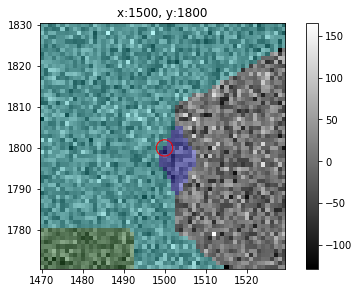

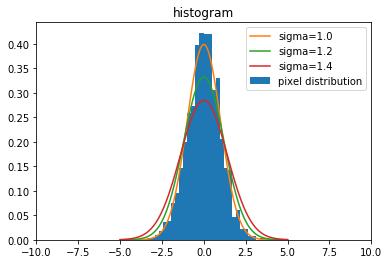

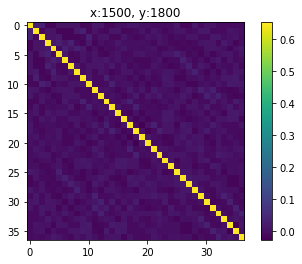

In [167]:
single_position = diasource_analyzer.cutout_analysis(1500, 1800, 
                                                     fill=False,
                                                     clip_image=True,alpha=0.05,
                                                     image_show=True, hist_show=True, cov_show=True)
single_position

Here is another example

{'mean': 0.8942984,
 'vari_image': 1548.7405,
 'mean_of_vari': 1602.0018,
 'standard_norm_p': 0.6216429667211832,
 'standard_norm_test': 'consistent',
 'skybk_p': 0.8842557080034577,
 'skybk_test': 'consistent',
 'covariance': -0.12187973081396905}

<Figure size 432x288 with 0 Axes>

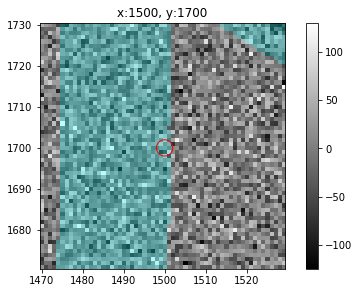

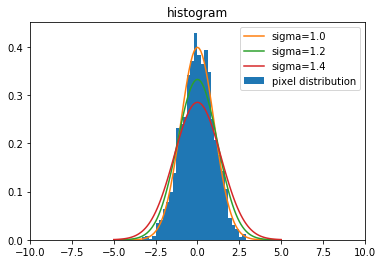

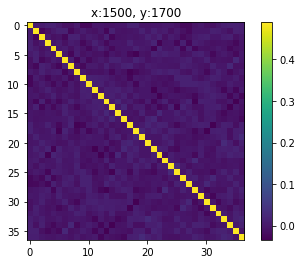

In [168]:
single_position = diasource.cutout_analysis(1500, 1700, 
                                            fill=False, clip_image=True,
                                            alpha=0.05, image_show=True, hist_show=True, cov_show=True)
single_position

Note that it is good to not fill the masked region by 0 here. Because that could cause the distribution of the post stams do not agree with the distribution of the global skybackground.

#### check global statistics

In [169]:
global_analysis=diasource.image_statistics(fill=False, clip_image=True, alpha=0.05)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


All pixels of this post-stamp are masked.
All pixels of this post-stamp are masked.
All pixels of this post-stamp are masked.
All pixels of this post-stamp are masked.
All pixels of this post-stamp are masked.
All pixels of this post-stamp are masked.
All pixels of this post-stamp are masked.


In [170]:
global_analysis.show_in_notebook()

idx,image_mean,image_var,mean_of_var,cov,standard_norm,skybk
0,0.67975336,1608.1395,1603.8827,nan,0.8444444444444444,0.8740740740740741
